In [1]:
import pandas as pd
from tech_core.feature_pipeline import FeaturesPipeline
from tech_core.losses import StreamingSharpeLoss
from tech_core.nn_builder import SimplePortfolioAllocator, DeepPortfolioAllocator_1
import torch
from tqdm import tqdm
# ??? Should we make different train periods for different models?

In [2]:
path_to_data = '../data/'

split_dates = [
    pd.Timestamp("2025-01-01")
]
split_names = ['train', 'test']

fee = 1.53e-4 * 3
padding = 35
batch_size_config = {
    0: 1000,
    # 40: 4000,
    # 80: 10000
}
num_epochs = 200
adam_lr = 1e-1
log_freq = 5

In [3]:
prev_models = []

batch_size = batch_size_config[0]
pipeline = FeaturesPipeline(
    path_to_data,
    padding=padding,
    batch_size=batch_size,
    split_dates=split_dates,
    split_names=split_names
)

cmf_dim = asset_dim = num_assets = None
for common_feats, asset_feats, fut_ret, _, _ in tqdm(pipeline.iterate('train'), desc="Loading features"):
    cmf_dim = common_feats.shape[1]
    asset_dim = asset_feats.shape[2]
    num_assets = asset_feats.shape[1]
    break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Loading features: 0it [00:00, ?it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Changing batch size to 1000 at epoch 0


  2%|▏         | 4/200 [03:42<2:56:50, 54.13s/it]

Sharpe Ratio for the epoch: 2.1119
Average Weights:



,Weight
IP,9.627229e-01
IRM,1.332598e-02
GRMN,9.619288e-03
JPM,4.450679e-03
TRGP,1.602726e-03
...,...
AAL,9.213419e-08
RMD,8.227455e-08
ALB,8.050583e-08
PODD,6.337993e-08


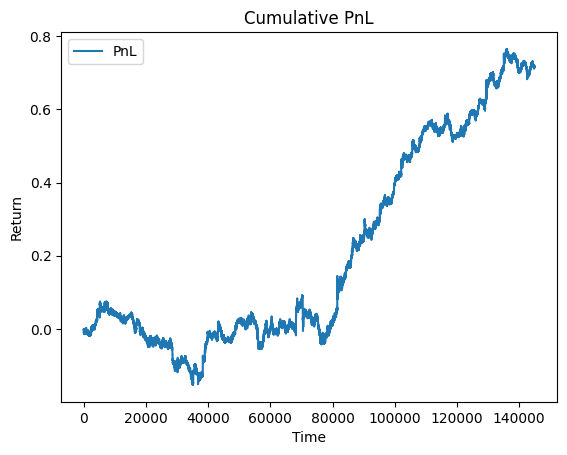

Epoch 5: Loss = 7.856643199920654
Sharpe Ratio for the epoch: 0.9980
Average Weights:



,Weight
IP,9.417880e-01
IRM,2.169080e-02
GRMN,1.546274e-02
JPM,6.471092e-03
TRGP,1.905742e-03
...,...
AAL,1.356037e-07
RMD,1.211502e-07
ALB,1.183960e-07
PODD,9.313016e-08


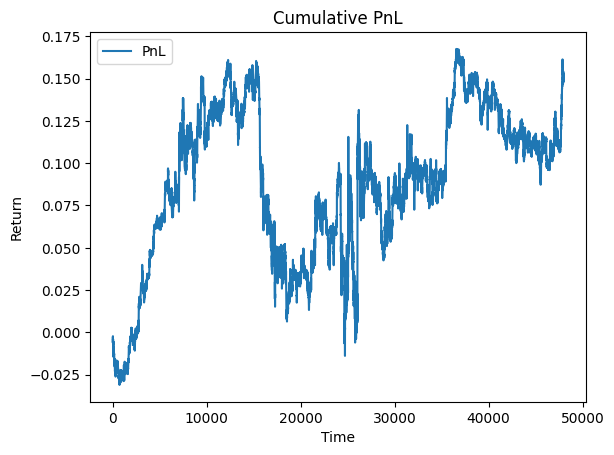

  4%|▍         | 9/200 [07:58<2:43:12, 51.27s/it]

Sharpe Ratio for the epoch: 1.5762
Average Weights:



,Weight
BKNG,9.987983e-01
IP,5.143502e-04
GRMN,1.488502e-04
PTC,1.469685e-04
FFIV,1.229053e-04
...,...
AAL,7.691622e-10
RMD,7.132232e-10
ALB,6.732033e-10
PODD,5.530268e-10


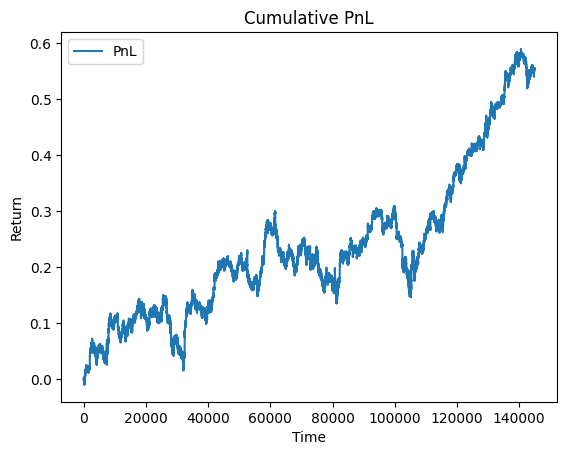

Epoch 10: Loss = 0.7837650179862976
Sharpe Ratio for the epoch: 1.7042
Average Weights:



,Weight
BKNG,9.987323e-01
IP,5.459245e-04
GRMN,1.560523e-04
PTC,1.554600e-04
FFIV,1.294701e-04
...,...
AAL,7.977574e-10
RMD,7.395487e-10
ALB,6.976074e-10
PODD,5.720805e-10


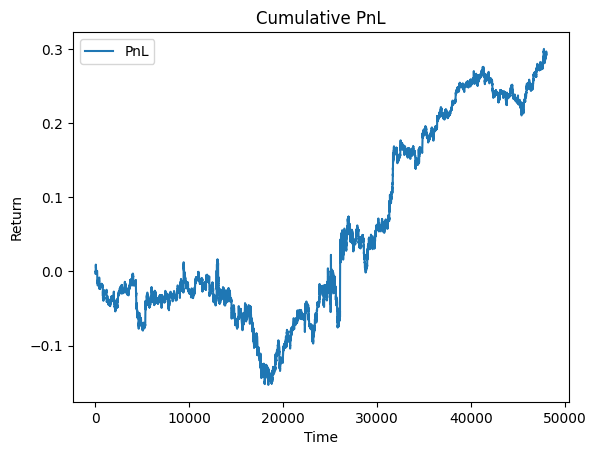

  5%|▌         | 10/200 [08:59<2:50:51, 53.96s/it]


KeyboardInterrupt: 

In [4]:
from copy import deepcopy

loss_fn = StreamingSharpeLoss(
    fee=fee,
    asset_names=pipeline.reader.asset_names + ['Cash'],
)

prev_models = []
for i in range(len(prev_models), 10):

    # ad-hoc so far, mb add this to pipeline
    train_cash_left = []
    for common_feats_old, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

        # Перевод в тензоры
        common_feats = torch.tensor(common_feats_old.values, dtype=torch.float32).to(device)       # (T, d_common)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

        if len(common_feats) != batch_size:
            continue

        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            common_feats_tmp = common_feats_old.copy()
            common_feats_tmp['cash_left'] = cash_left.detach().numpy()
            common_feats_tmp = torch.tensor(common_feats_tmp.values, dtype=torch.float32).to(device)
            cash_left *= prev_model(common_feats_tmp, asset_feats)[:, -1:]

        train_cash_left.append(cash_left.detach())
    
    test_cash_left = []
    for common_feats_old, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):

        common_feats = torch.tensor(common_feats_old.values, dtype=torch.float32).to(device)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)
        
        if len(common_feats) != batch_size:
            continue

        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            common_feats_tmp = common_feats_old.copy()
            common_feats_tmp['cash_left'] = cash_left.detach().numpy()
            common_feats_tmp = torch.tensor(common_feats_tmp.values, dtype=torch.float32).to(device)
            cash_left *= prev_model(common_feats_tmp, asset_feats)[:, -1:]
        test_cash_left.append(cash_left.detach())

    model = SimplePortfolioAllocator(
        cmf_dim=cmf_dim + 1,
        num_assets=num_assets,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)

    for epoch in tqdm(range(num_epochs)):
        if epoch in batch_size_config:
            print(f"Changing batch size to {batch_size_config[epoch]} at epoch {epoch}")
            batch_size = batch_size_config[epoch]
            pipeline = FeaturesPipeline(
                path_to_data,
                padding=padding,
                batch_size=batch_size,
                split_dates=split_dates,
                split_names=split_names
            )

        loss_fn.reset()
        pipeline.reset()
        for (common_feats, asset_feats, fut_ret, min_prices, market_caps), cash_left in zip(pipeline.iterate('train'), train_cash_left):

            common_feats['cash_left'] = cash_left.squeeze()

            common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
            asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
            fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
            min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
            market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

            if len(common_feats) != batch_size:
                continue

            optimizer.zero_grad()

            # Вычисляем веса
            weights = model(common_feats, asset_feats)

            # Обновляем метрику
            loss_value = loss_fn.forward(
                weights=weights,
                returns=fut_ret,
                prev_model_cash=cash_left,
                min_prices=min_prices,
                market_caps=market_caps
            )
            loss_value.backward()

            optimizer.step()

        if (epoch + 1) % log_freq == 0:
            _, weights_df = loss_fn.plot_whole_epoch_loss()
            weights_df.to_csv(f'weights_iteration_{i}_epoch_{epoch + 1}.csv')
            torch.save(model.state_dict(), f'model_iteration_{i}_epoch_{epoch + 1}.pth')
            print(f"Epoch {epoch + 1}: Loss = {loss_value.item()}")
        loss_fn.reset()  # Сбрасываем метрику для следующей эпохи

        for (common_feats, asset_feats, fut_ret, min_prices, market_caps), cash_left in zip(pipeline.iterate('test'), test_cash_left):

            common_feats['cash_left'] = cash_left.squeeze()  # Добавляем cash_left в общие признаки

            common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
            asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
            fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
            min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
            market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)

            if len(common_feats) !=  batch_size:
                continue

            weights = model(common_feats, asset_feats)
            loss_fn.forward(weights=weights, returns=fut_ret, prev_model_cash=cash_left, min_prices=min_prices, market_caps=market_caps)

        if (epoch + 1) % log_freq == 0:
            loss_fn.plot_whole_epoch_loss()
        loss_fn.reset()

    prev_models.append(deepcopy(model))
    print(f"Iteration {i + 1} completed.")